## **Process Articles**

This Python Notebook reads in a Google Sheets document (or csv) containing  deduplicated search results from Scopus and Google Scholar on the topic of GIS methods in Food Systems Research.

Articles are then screened to assess relevance based on terms in the title, abstract, and author and index keywords.

Relevance screening was also performed by Generative AI platforms (Claude and two models from ChatGPT). Results are included in the spreadsheet and are compared to assess consistency with each other and with the manual and Python-based screening approaches.

Screening performance is compared between automated and manual methods by calculating consistency across the methods and generating a confusion matrix.

Relevant articles are also screened for methods and theory-related keywords. These keywords are then summarized by frequency and in word clouds.

### Set Up

In [1]:
# import libraries

import copy
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud, STOPWORDS
from sklearn.metrics import confusion_matrix

warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.display.max_colwidth = 300

### Term Lists

In [2]:
# list of screening terms for assessing relevance

flaglist = [
    # false positives on GI
    'geographical indication', 'glycemic index', 'governmental initiatives',
    # false positives on spatial
    'spatial frequency domain imaging',
    # hydrology
    'aquifer', 'coastal reclamation', 'flood', 'water resources', 'evaporation',
    'heavy metal',
    # medicine
    'parasitology', 'medical device', 'aetiology', 'primary care provider',
    # ecology & biology
    'wildlife', 'primate', 'waterfowl habitat', 'mice',
    # urban planning, public safety, education
    'traffic accident', 'crime', 'school choice',
    # climate science
    'sequestration', 'bioenergy',
    # systematic reviews
    'comprehensive review', 'systematic literature review',
    # economics (non-spatial)
    'games', 'monetization', 'light industry'
]

termdict = {
    'LULC': ['land use', 'land cover'],
    'relevant': ['food desert', 'vegetable', 'food system', 'food production'],
    'irrelevant': flaglist
}

In [3]:
# list of GIS method terms
method_terms = {
    'aerial',
    'agent-based modeling',
    'analytical hierarchy',
    'arcgis',
    'artificial intelligence',
    'big data',
    'buffer',
    'cartography',
    'change detection',
    'classification',
    'cloud',
    'cluster',
    'convolutional neural network',
    'crowdsource',
    'curve fit',
    'dashboard',
    'data science',
    'decision support',
    'deep learning',
    'density',
    'disaster management',
    'environmental modeling',
    'exponential smoothing',
    'forecast',
    "geary's c",
    'geoai',
    'geocoding',
    'geocomputing',
    'geodesy',
    'geoinformatics',
    'geomatics',
    'geophysics',
    'geoprocessing',
    'georeferencing',
    'geostatistics',
    'geovisualization',
    'gis modeling',
    'gps',
    'hot spot',
    'hydrological modeling',
    'hydrology',
    'hyperspectral',
    'image classification',
    'imagery',
    'imagery analysis',
    'integrated mesh',
    'interpolation',
    'inverse distance weighting',
    'kriging',
    'lidar',
    'lisa',
    'location intelligence',
    'machine learning',
    "moran's i",
    'natural resource management',
    'network analysis',
    'optimization',
    'overlay',
    'participatory',
    'point cloud',
    'precision agriculture',
    'prediction',
    'proximity',
    'qgis',
    'random forest',
    'recurrent neural network',
    'regression',
    'remote sensing',
    'satellite imagery',
    'slope analysis',
    'space-time',
    'spatial analysis',
    'spatial autocorrelation',
    'spatial database',
    'spatial econometrics',
    'spatial optimization',
    'spatial statistics',
    'spatiotemporal',
    'splines',
    'storymap',
    'surface analysis',
    'terrain analysis',
    'terrain modeling',
    'vgi',
    'viewshed',
    'web map',
    'web service',
    'xgboost'
 }

In [4]:
# list of theory terms
theory_terms = {
    'theory',
    'conceptual',
    'framework',
    'paradigm',
    'scholarship',
    'approach',
    'intervention',
    'critical' ,
    'critique',
    'agency',
    'power',
    'modernity'
    }

### Functions

In [5]:
# function to access data from google sheet or csv

# source: google colab
# prompt: read in a sheet from a google sheet
# modified by author

def read_data(source = 'Articles_GISinFoodSystemsResearch', method = 'googlesheet'):
  '''
  source: name of the google sheet or path to csv file
  method: googlesheet or csv
  '''

  if method == 'googlesheet':

    !pip install --upgrade gspread

    from google.colab import auth
    auth.authenticate_user()

    import gspread
    from google.auth import default
    creds, _ = default()

    gc = gspread.authorize(creds)

    worksheet = gc.open(source).sheet1
    # worksheet = gc.open(source).worksheet(sheetname)
    rows = worksheet.get_all_values()
    headers = rows.pop(0)
    rawdf = pd.DataFrame(rows, columns=headers)

  elif method == 'csv':
    rawdf = pd.read_csv(source)

  else:
    raise ValueError("Method must be 'googlesheet' or 'csv'")

  return rawdf

In [6]:
# function to screen articles

def assess_relevant(rawdf,keywords,conditions=['LULC','flags','agroforestry'], other=False, other_list=None):
  # other can be used to search for method or theory terms

  # Initialize the new df and columns for relevance and reason
  df = copy.deepcopy(rawdf)
  df['RELEVANCE_clean'] = df['REL_INITIALMANUALCODING'].map({'TRUE':True, 'FALSE':False})
  df['PYTHON RELEVANCE'] = True
  df['PYTHON REASON'] = ''
  if other:
    df[f"{other}_TERMS"] = ''


  # Loop through the titles, abstracts, and keywords to classify the articles
  for idx, row in df.iterrows():
      abstract = str(row['Abstract']).lower()  # Convert to lowercase for case-insensitive matching
      title = str(row['Title']).lower()
      keywds = str(row['Author Keywords']).lower() + ', ' + str(row['Index Keywords']).lower()
      alltext = title + ' ' + abstract + ' ' + keywds

      if 'LULC' in conditions:
        # condition to search for LULC related terms
        if any(x.lower() in alltext for x in keywords['LULC']):
              relevance = ''
              df.at[idx, 'PYTHON REASON'] += f"LULC "
              df.at[idx, 'PYTHON RELEVANCE'] = relevance

      if 'flags' in conditions:
        # condition to search for flags
        for word in keywords['irrelevant']:
            if word in alltext:
                df.at[idx, 'PYTHON REASON'] += f"{word} "
                df.at[idx, 'PYTHON RELEVANCE'] = False

      if 'agroforestry' in conditions:
        # condition to search for agroforestry
        if alltext.count('agroforestry') > 0:
            df.at[idx, 'PYTHON REASON'] += f"AGROFORESTRY"
            df.at[idx, 'PYTHON RELEVANCE'] = True

      if other:
        # search for other terms and add to a new col
        for word in other_list:
          if word in alltext:
            df.at[idx, f'{other}_TERMS'] += f"{word}; "

  return df

In [7]:
# function to assess the performance of two screening methods

def assess_screening(rawdf,colname1='RELEVANCE_clean', colname2='PYTHON RELEVANCE'):
  # Initialize the new df and columns for relevance and reason
  df = copy.deepcopy(rawdf)
  df[colname1] = df[colname1].replace({'TRUE': True, 'FALSE': False})
  df[colname2] = df[colname2].replace({'TRUE': True, 'FALSE': False})

  # add assessment of two coding methods
  df['true_positive'] = (df[colname1] == True) & (df[colname2] == True)
  df['true_negative'] = (df[colname1] == False) & (df[colname2] == False)
  df['false_positive'] = (df[colname1] == False) & (df[colname2] == True)
  df['false_negative'] = (df[colname1] == True) & (df[colname2] == False)

  for col in ['true_positive','true_negative','false_positive','false_negative']:
      df[col] = df[col].astype(int)

  return df

In [8]:
# function to return performance stats for screening method assessment

def summarize_results(df):
  tp_count = df['true_positive'].sum()
  tn_count = df['true_negative'].sum()
  fp_count = df['false_positive'].sum()
  fn_count = df['false_negative'].sum()

  total_count = tp_count + tn_count + fp_count + fn_count

  FPR = fp_count / (fp_count + tn_count)
  ACCURACY = (tp_count + tn_count) / total_count
  RECALL_TPR = tp_count / (tp_count + fn_count)
  PRECISION = tp_count / (tp_count + fp_count)

  return {
      'tc': total_count,
      'tp': tp_count,
      'tn': tn_count,
      'fp': fp_count,
      'fn': fn_count,
      'fpr': FPR,
      'accuracy': ACCURACY,
      'recall': RECALL_TPR,
      'precision': PRECISION
      }

In [9]:
# function to generate a confusion matrix

def make_confusion_matrix(df,norm='all'):
  subdf = df.dropna(subset=['RELEVANCE_clean'])
  subdf = subdf[subdf['RELEVANCE_clean']!= '']
  subdf = subdf[subdf['PYTHON RELEVANCE']!= '']
  subdf['RELEVANCE_clean'] = subdf['RELEVANCE_clean'].astype(int)
  subdf['PYTHON RELEVANCE'] = subdf['PYTHON RELEVANCE'].astype(int)
  cm = confusion_matrix(subdf['RELEVANCE_clean'], subdf['PYTHON RELEVANCE'], normalize=norm)
  cm = np.round(cm, decimals=2)
  sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
  plt.xlabel('Python screening')
  plt.ylabel('Manual screening')
  ax = plt.gca()
  ax.set_yticklabels(['Not Relevant', 'Relevant'])
  ax.set_xticklabels(['Not Relevant', 'Relevant'])
  plt.show()
  return cm

In [10]:
# function to select random articles for spotchecking

# source: google colab
# prompt: add a column to df that has 1 for 55 of the total rows and is blank for all other rows
# modified by author

def spotcheck(df,num_to_spotcheck=55):
  # Create a new column filled with NaN
  df['SPOTCHECK'] = np.nan

  # Randomly select indices
  selected_indices = np.random.choice(df.index, size=num_to_spotcheck, replace=False)

  # Assign 1 to the selected indices
  df.loc[selected_indices, 'SPOTCHECK'] = 1

  return df

In [11]:
# function to generate word cloud

def wordcloud(df,col='METHOD_TERMS'):
  # Combine all text into a single string
  text = ', '.join(df[col]).replace(';',',')

  # Create a WordCloud object
  wordcloudobj = WordCloud(
      width=800,
      height=400,
      background_color='white',
      collocations=True, # False separates word pairs
      stopwords=STOPWORDS
  ).generate(text)

  # Display the word cloud
  plt.figure(figsize=(8, 8), facecolor=None)
  plt.imshow(wordcloudobj)
  plt.axis("off")
  plt.tight_layout(pad=0)
  plt.show()

In [12]:
# function to count word frequencies

def term_frequency(df,col,csv=False):
  text_list = [x.strip() for x in '; '.join(df[col]).split(';')]
  freqdf = pd.DataFrame.from_dict(Counter(text_list), orient='index', columns=['frequency'])
  freqdf = freqdf.sort_values('frequency', ascending=False)
  if csv:
    freqdf.to_csv(f"Frequencies_{col}.csv")
  return freqdf

### Modify Fonts (optional)

In [16]:
!sudo apt install msttcorefonts -qq

The following additional packages will be installed:
  cabextract distro-info libmspack0 python3-chardet python3-debconf
  python3-debian python3-distro-info python3-distupgrade
  python3-update-manager python3-yaml ubuntu-advantage-tools ubuntu-pro-client
  ubuntu-pro-client-l10n ubuntu-release-upgrader-core update-manager-core
  update-notifier-common xfonts-encodings xfonts-utils zstd
Suggested packages:
  shunit2
The following NEW packages will be installed:
  cabextract distro-info libmspack0 python3-chardet python3-debconf
  python3-debian python3-distro-info python3-distupgrade
  python3-update-manager python3-yaml ttf-mscorefonts-installer
  ubuntu-advantage-tools ubuntu-pro-client ubuntu-pro-client-l10n
  ubuntu-release-upgrader-core update-manager-core update-notifier-common
  xfonts-encodings xfonts-utils zstd
0 upgraded, 20 newly installed, 0 to remove and 41 not upgraded.
Need to get 2,364 kB of archives.
After this operation, 9,974 kB of additional disk space will be used

In [17]:
!rm ~/.cache/matplotlib -rf

In [18]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

In [19]:
import matplotlib.pyplot as plt
from matplotlib import font_manager

# If you installed the font using apt-get
font_dir = '/usr/share/fonts/truetype/msttcorefonts'
font_files = font_manager.findSystemFonts(fontpaths=font_dir)
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

# Set Times New Roman as the default font
plt.rcParams['font.family'] = 'Times New Roman'

### Article Screening

In [13]:
# access data

rawdf = read_data(source = 'Articles_GISinFoodSystemsResearch', method = 'googlesheet')

In [14]:
# screen articles

df = assess_relevant(rawdf,termdict)

# display the updated dataframe with relevance and reason columns
df[['Title','RELEVANCE_clean', 'PYTHON RELEVANCE', 'PYTHON REASON']].head(7)

,Title,RELEVANCE_clean,PYTHON RELEVANCE,PYTHON REASON
0,Mapping socio-environmental pressures to assess Portuguese soil vulnerability,False,,LULC
1,"COVID-19 Interventions in an informal settlement: A spatial analysis of accessibility in Kibera, Kenya",False,True,
2,Potential for climate change driven spatial mismatches between apple crops and their wild bee pollinators at a continental scale,True,,LULC
3,Predicting human-wildlife interaction in urban environments through agent-based models,False,False,wildlife
4,Improving Crop Classification Accuracy with Integrated Sentinel-1 and Sentinel-2 Data: a Case Study of Barley and Wheat,True,True,
5,Identification of coconut palm trees using single shot detector deep learning model,True,True,
6,Socioeconomic distribution of food outlet availability through online food delivery services in seven European countries: A cross-sectional study,True,True,


### Assess Screening Performance

In [ ]:
# compare Python screening results to manual screening results

df = assess_screening(df)
summarize_results(df)

{'tc': 449,
 'tp': 276,
 'tn': 113,
 'fp': 37,
 'fn': 23,
 'fpr': 0.24666666666666667,
 'accuracy': 0.8663697104677061,
 'recall': 0.9230769230769231,
 'precision': 0.8817891373801917}

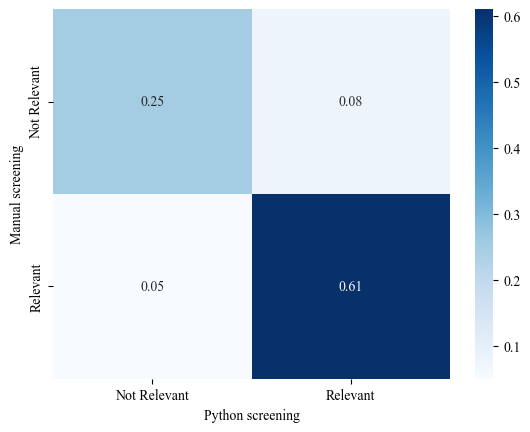

array([[0.25, 0.08],
       [0.05, 0.61]])

In [20]:
# generate confusion matrix

make_confusion_matrix(df)

In [ ]:
# compare manual with chatgpt 1
df1 = assess_screening(df,colname1='RELEVANCE_clean', colname2='ChatGPT1RELEVANCE')
print(f"COMPARE MANUAL SCREENING TO CHATGPT MODEL 1:\n{summarize_results(df1)}\n")

# compare manual with chatgpt 2
df2 = assess_screening(df,colname1='RELEVANCE_clean', colname2='ChatGPT2RELEVANCE')
print(f"COMPARE MANUAL SCREENING TO CHATGPT MODEL 2:\n{summarize_results(df2)}\n")

# compare chatgpt 1 and 2
df3 = assess_screening(df,colname1='ChatGPT1RELEVANCE', colname2='ChatGPT2RELEVANCE')
print(f"COMPARE CHATGPT MODEL 1 to CHATGPT MODEL 2:\n{summarize_results(df3)}")

COMPARE MANUAL SCREENING TO CHATGPT MODEL 1:
{'tc': 541, 'tp': 50, 'tn': 168, 'fp': 15, 'fn': 308, 'fpr': 0.08196721311475409, 'accuracy': 0.4029574861367837, 'recall': 0.13966480446927373, 'precision': 0.7692307692307693}

COMPARE MANUAL SCREENING TO CHATGPT MODEL 2:
{'tc': 541, 'tp': 90, 'tn': 146, 'fp': 37, 'fn': 268, 'fpr': 0.20218579234972678, 'accuracy': 0.43622920517560076, 'recall': 0.25139664804469275, 'precision': 0.7086614173228346}

COMPARE CHATGPT MODEL 1 to CHATGPT MODEL 2:
{'tc': 1095, 'tp': 31, 'tn': 731, 'fp': 243, 'fn': 90, 'fpr': 0.24948665297741274, 'accuracy': 0.6958904109589041, 'recall': 0.256198347107438, 'precision': 0.11313868613138686}


### Methods and Theory Screening

In [21]:
# access relevant articles

reldf = copy.deepcopy(rawdf[rawdf['FINAL_RELEVANCE']=='TRUE'])

In [22]:
# screen for methods-related terms

methods_df = assess_relevant(reldf,termdict,other='METHOD',other_list=method_terms)
methods_df[['Title','RELEVANCE_clean', 'PYTHON RELEVANCE', 'METHOD_TERMS']].head(7)

,Title,RELEVANCE_clean,PYTHON RELEVANCE,METHOD_TERMS
2,Potential for climate change driven spatial mismatches between apple crops and their wild bee pollinators at a continental scale,True,,spatial analysis;
4,Improving Crop Classification Accuracy with Integrated Sentinel-1 and Sentinel-2 Data: a Case Study of Barley and Wheat,True,True,classification; remote sensing; cloud; random forest; regression; image classification;
5,Identification of coconut palm trees using single shot detector deep learning model,True,True,remote sensing; arcgis; deep learning;
6,Socioeconomic distribution of food outlet availability through online food delivery services in seven European countries: A cross-sectional study,True,True,
7,Urban microclimate simulations based on GIS data to mitigate thermal hot-spots: Tree design scenarios in an industrial area of Florence,True,True,hot spot; qgis;
8,Climate-related spatial reduction risk of agricultural lands on the Mediterranean coast in Türkiye and scenario-based modelling of urban growth,True,,spatiotemporal;
9,Integrating socio-spatial preference heterogeneity into the assessment of the aesthetic quality of a Mediterranean agricultural landscape,True,True,spatial analysis;


In [23]:
method_freq = term_frequency(methods_df,'METHOD_TERMS')
method_freq.head(10)

,frequency
,924
spatial analysis,161
remote sensing,129
regression,99
density,82
classification,70
spatiotemporal,59
cluster,58
imagery,53
proximity,52


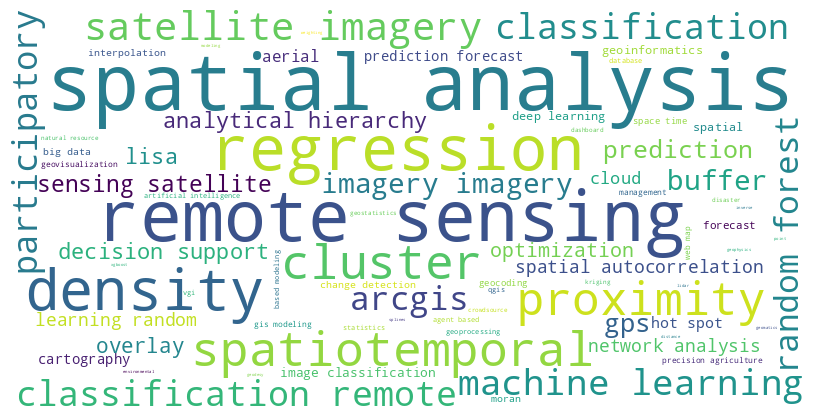

In [24]:
wordcloud(methods_df,col='METHOD_TERMS')

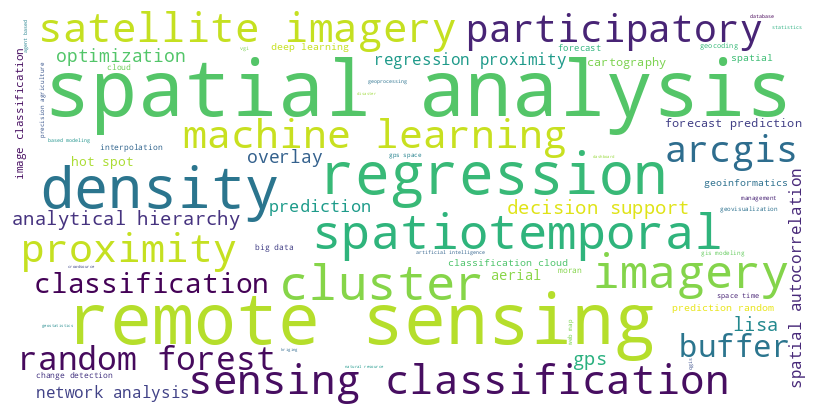

In [ ]:
wordcloud(methods_df,col='METHOD_TERMS')

In [25]:
# screen for theory-related terms

theory_df = assess_relevant(reldf,termdict,other='THEORY',other_list=theory_terms)
theory_df[['Title','RELEVANCE_clean', 'PYTHON RELEVANCE', 'THEORY_TERMS']].head(7)

,Title,RELEVANCE_clean,PYTHON RELEVANCE,THEORY_TERMS
2,Potential for climate change driven spatial mismatches between apple crops and their wild bee pollinators at a continental scale,True,,approach;
4,Improving Crop Classification Accuracy with Integrated Sentinel-1 and Sentinel-2 Data: a Case Study of Barley and Wheat,True,True,approach;
5,Identification of coconut palm trees using single shot detector deep learning model,True,True,
6,Socioeconomic distribution of food outlet availability through online food delivery services in seven European countries: A cross-sectional study,True,True,
7,Urban microclimate simulations based on GIS data to mitigate thermal hot-spots: Tree design scenarios in an industrial area of Florence,True,True,intervention;
8,Climate-related spatial reduction risk of agricultural lands on the Mediterranean coast in Türkiye and scenario-based modelling of urban growth,True,,critical;
9,Integrating socio-spatial preference heterogeneity into the assessment of the aesthetic quality of a Mediterranean agricultural landscape,True,True,


In [26]:
theory_freq = term_frequency(theory_df,'THEORY_TERMS')
theory_freq.head(20)

,frequency
,924
approach,261
framework,102
intervention,58
critical,58
power,33
conceptual,24
theory,24
agency,14
paradigm,7


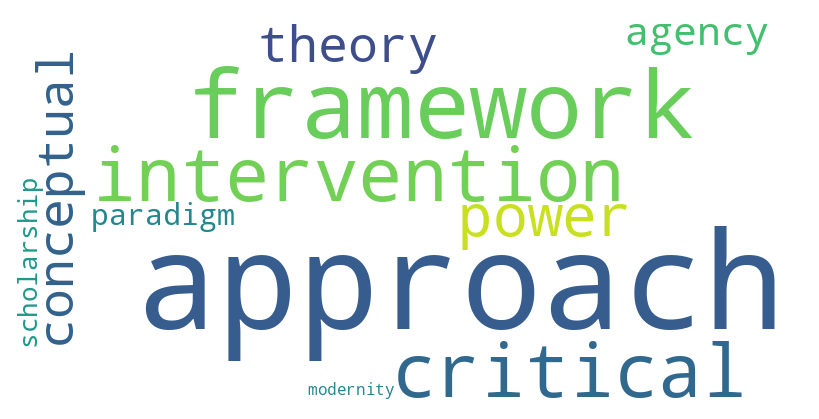

In [ ]:
wordcloud(theory_df,col='THEORY_TERMS')

In [27]:
theory_df.to_csv("theory.csv")